In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('/content/labeled_dataset.xlsx')

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
df = df[['sentence', 'topic', 'type', 'biased_words4', 'Label_bias', 'Label_opinion']]

In [ ]:
nan_mask = df.isna().sum()
print(nan_mask)

sentence         0
topic            0
type             0
biased_words4    0
Label_bias       0
Label_opinion    0
dtype: int64


In [ ]:
# Drop rows where Label_bias is "No agreement"
df = df[df['Label_bias'] != 'No agreement']
df.shape

(1551, 6)

In [ ]:
nan_mask = df.isna().sum()
print(nan_mask)

sentence         0
topic            0
type             0
biased_words4    0
Label_bias       0
Label_opinion    0
dtype: int64


In [ ]:
def create_final_label(row):
    if row['Label_bias'] == 'Biased' and row['Label_opinion'] == "Expresses writer’s opinion":
        return 'Opinion'
    elif row['Label_bias'] == 'Biased':
        return 'Biased'
    elif row['Label_bias'] == 'Non-biased' and row['Label_opinion'] == 'Entirely factual':
        return 'Unbiased'
    elif row['Label_bias'] == 'Non-biased' or row['Label_opinion'] == "Expresses writer’s opinion":
        return 'Unbiased'
    else:
        return 'Unknown'

df['label_final'] = df.apply(create_final_label, axis=1)


In [ ]:
nan_mask = df.isna().sum()
print(nan_mask)

sentence         0
topic            0
type             0
biased_words4    0
Label_bias       0
Label_opinion    0
label_final      0
dtype: int64


In [ ]:
df['label_final'].value_counts()

,count
label_final,
Unbiased,533
Biased,527
Opinion,491


Cleaning the dataset further


In [ ]:
import re
import ast

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

df['sentence'] = df['sentence'].apply(clean_text)

# Convert string-lists to actual lists (for biased_words4)
df['biased_words'] = df['biased_words4'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])


df.drop('biased_words4', axis=1, inplace=True)

In [ ]:
df.head(3)

,sentence,topic,type,Label_bias,Label_opinion,label_final,biased_words
0,youtube is making clear there will be no birth...,elections-2020,center,Biased,Somewhat factual but also opinionated,Biased,"[belated, birtherism]"
1,the increasingly bitter dispute between americ...,sport,left,Non-biased,Entirely factual,Unbiased,[bitter]
2,so while there may be a humanitarian crisis dr...,immigration,left,Biased,Expresses writer’s opinion,Opinion,[crisis]


In [ ]:
df = pd.get_dummies(df, columns=['topic', 'type'])


In [ ]:
nan_mask = df.isna().sum()
print(nan_mask)

sentence                                       0
Label_bias                                     0
Label_opinion                                  0
label_final                                    0
biased_words                                   0
topic_abortion                                 0
topic_coronavirus                              0
topic_elections-2020                           0
topic_environment                              0
topic_gender                                   0
topic_gun-control                              0
topic_immigration                              0
topic_international-politics-and-world-news    0
topic_middle-class                             0
topic_sport                                    0
topic_student-debt                             0
topic_trump-presidency                         0
topic_vaccines                                 0
topic_white-nationalism                        0
type_center                                    0
type_left           

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Reshape to 2D since it's a single column
ohe = OneHotEncoder(sparse_output=False)
label_encoded = ohe.fit_transform(df[['label_final']])  # Output will be a NumPy array

# Create a new DataFrame with the one-hot encoded labels
label_df = pd.DataFrame(label_encoded, columns=ohe.get_feature_names_out(['label_final']))

df = df.reset_index(drop=True)  # Reset index of the original DataFrame
label_df = label_df.reset_index(drop=True)
# Concatenate with the original dataframe
df = pd.concat([df, label_df], axis=1)

In [ ]:
label_df.value_counts()

,,,count
label_final_Biased,label_final_Opinion,label_final_Unbiased,
0.0,0.0,1.0,533
1.0,0.0,0.0,527
0.0,1.0,0.0,491


In [ ]:
df.columns

Index(['sentence', 'Label_bias', 'Label_opinion', 'label_final',
       'biased_words', 'topic_abortion', 'topic_coronavirus',
       'topic_elections-2020', 'topic_environment', 'topic_gender',
       'topic_gun-control', 'topic_immigration',
       'topic_international-politics-and-world-news', 'topic_middle-class',
       'topic_sport', 'topic_student-debt', 'topic_trump-presidency',
       'topic_vaccines', 'topic_white-nationalism', 'type_center', 'type_left',
       'type_right', 'label_final_Biased', 'label_final_Opinion',
       'label_final_Unbiased'],
      dtype='object')

Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split on sentence and label
X_text = df['sentence']
y = df['label_final']

X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)


# Extract meta features (topics, types, num_biased_words)
meta_cols = [col for col in df.columns if col.startswith('topic_') or col.startswith('type_')]
X_meta = df[meta_cols]

# Step 5: Match indices to get corresponding meta features
X_train_meta = X_meta.loc[X_train_text.index].values
X_val_meta = X_meta.loc[X_val_text.index].values

target_cols = [col for col in df.columns if col.startswith('label_final_')]
y_train_final = df.loc[X_train_text.index, target_cols].values
y_val_final = df.loc[X_val_text.index, target_cols].values




In [ ]:
#saving the final encoded dataset
df.to_excel('final_encoded_dataset.xlsx', index=False)

In [ ]:
np.save('y_train_enc.npy', y_train_final)
np.save('y_val_enc.npy', y_val_final)

# Embeddings


In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Define BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model_bert(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    except Exception as e:
        print(f"Error processing: {text} → {e}")
        return np.zeros(768)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Step 3: Generate BERT embeddings for training and validation
X_train_bert = np.array([get_bert_embeddings(text) for text in X_train_text])
X_val_bert = np.array([get_bert_embeddings(text) for text in X_val_text])

In [ ]:
# Step 6: Concatenate BERT + meta features
X_train_final = np.concatenate([X_train_bert, X_train_meta], axis=1)
X_val_final = np.concatenate([X_val_bert, X_val_meta], axis=1)

In [ ]:
np.save('X_train_final_mc.npy', X_train_final)
np.save('X_val_final_mc.npy', X_val_final)

# Model Training

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


# Load the numpy files - these are the BERT embeddings (768 dimensions)
X_train_final = np.load('/content/X_train_final_mc.npy')
X_val_final = np.load('/content/X_val_final_mc.npy')
y_train_final = np.load('/content/y_train_enc.npy')
y_val_final = np.load('/content/y_val_enc.npy')

print(f"Loaded data shapes:")
print(f"X_train_final: {X_train_final.shape}")
print(f"X_val_final: {X_val_final.shape}")
print(f"y_train_final: {y_train_final.shape}")
print(f"y_val_final: {y_val_final.shape}")

Loaded data shapes:
X_train_final: (1240, 785)
X_val_final: (311, 785)
y_train_final: (1240, 3)
y_val_final: (311, 3)


## BiLSTM model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 785, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 785, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 785, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 785, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,555 (1.19 MB)

 Trainable params: 310,851 (1.19 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3267 - loss: 1.4599
Epoch 1: val_accuracy improved from -inf to 0.37299, saving model to bias_detection_best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.3268 - loss: 1.4598 - val_accuracy: 0.3730 - val_loss: 1.0988
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3434 - loss: 1.4662
Epoch 2: val_accuracy improved from 0.37299 to 0.37621, saving model to bias_detection_best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.3438 - loss: 1.4648 - val_accuracy: 0.3762 - val_loss: 1.0995
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3727 - loss: 1.4133
Epoch 3: val_accuracy improved from 0.37621 to 0.38585, saving model to bias_detection_best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.3729 - loss: 1.4120 - val_accuracy: 0.3859 - val_loss: 1.1006
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3269 - loss: 1.4

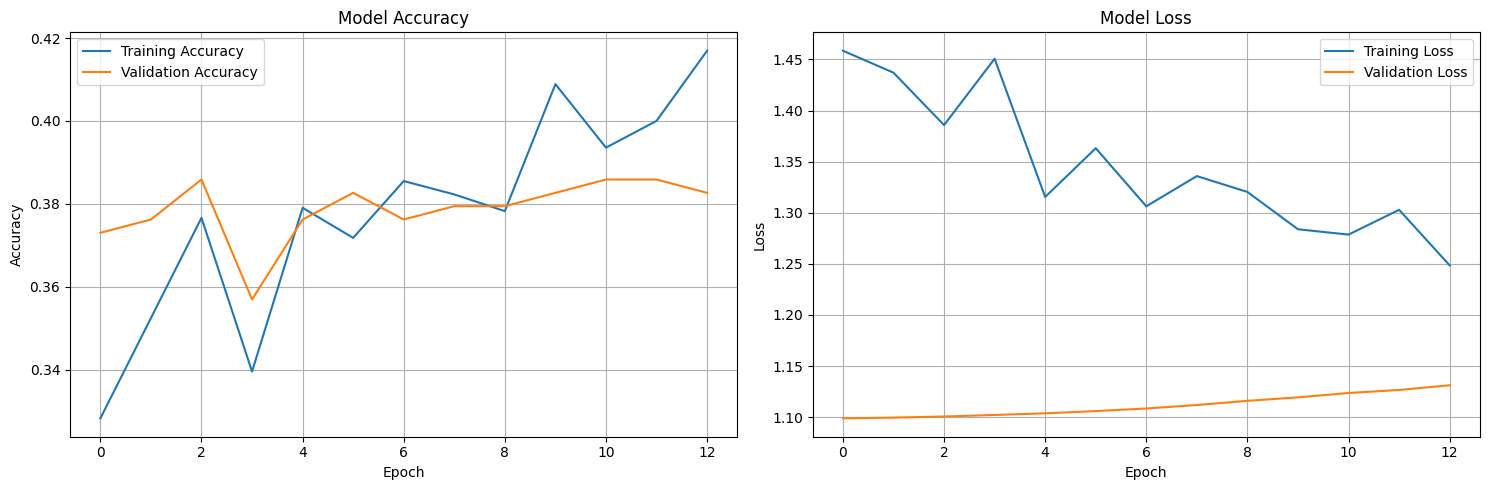

Best validation accuracy: 0.3859 (epoch 3)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4351 - loss: 1.0988
Final validation loss: 1.1006
Final validation accuracy: 0.3859
Final model saved to 'bias_detection_final_model.keras'
Best model saved to 'bias_detection_best_model.keras'


In [ ]:
# X_train_final: (1360, 785) - BERT embeddings
# X_val_final: (340, 785) - BERT embeddings
# y_train_final: (1360, 4) - One-hot encoded labels
# y_val_final: (340, 4) - One-hot encoded labels

# Model configuration parameters
input_dim = 785  # Feature dimension from BERT embeddings
num_classes = 3  # Number of bias classes
lstm_units = 128  # Size of LSTM units (increased for better feature learning)
dense_units = 96  # Size of dense layer
learning_rate = 5e-5  # Lower learning rate for more stable training
dropout_rate_lstm = 0.4  # Dropout after LSTM
dropout_rate_dense = 0.2  # Dropout after dense layer
batch_size = 64  # Larger batch size for more stable gradients
epochs = 50  # Maximum number of epochs
patience = 10  # Increased patience for early stopping

# Build the BiLSTM model
def build_bilstm_model():
    model = Sequential([
        # Reshape layer to convert 2D input to 3D for LSTM
        Reshape((input_dim, 1), input_shape=(input_dim,)),

        # Bidirectional LSTM layer
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(dropout_rate_lstm),
        BatchNormalization(),

        # Second Bidirectional LSTM layer for deeper feature extraction
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(dropout_rate_lstm),

        # Dense hidden layer with ReLU activation
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate_dense),
        BatchNormalization(),

        # Output layer with softmax activation for multi-class classification
        Dense(num_classes, activation='softmax')
    ])

    # Compile model with Adam optimizer and categorical crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = build_bilstm_model()
model.summary()

# Define callbacks
# 1. Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=patience,       # Number of epochs with no improvement
    restore_best_weights=True,  # Restore weights from the epoch with the best value
    verbose=1
)

# 2. Model checkpoint to save best model
model_checkpoint = ModelCheckpoint(
    filepath='bias_detection_best_model.keras',  # Path to save the model
    monitor='val_accuracy',                  # Monitor validation accuracy
    save_best_only=True,                    # Only save the best model
    verbose=1
)


# Add to model.fit
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")

# Plot the training history
plot_training_history(history)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val_final, y_val_final, verbose=1)
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")

# Save the final model (in addition to the best model saved during training)
model.save('bias_detection_final_model.keras')
print("Final model saved to 'bias_detection_final_model.keras'")
print("Best model saved to 'bias_detection_best_model.keras'")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │       402,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,627 (2.18 MB)

 Trainable params: 568,835 (2.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3276 - loss: 3.0401
Epoch 1: val_accuracy improved from -inf to 0.38907, saving model to bias_detection_best_model66.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.3279 - loss: 3.0380 - val_accuracy: 0.3891 - val_loss: 2.2059
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4054 - loss: 2.5571
Epoch 2: val_accuracy improved from 0.38907 to 0.47910, saving model to bias_detection_best_model66.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4054 - loss: 2.5567 - val_accuracy: 0.4791 - val_loss: 2.1391
Epoch 3/50
75/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4442 - loss: 2.3862
Epoch 3: val_accuracy improved from 0.47910 to 0.61415, saving model to bias_detection_best_model66.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4449 - loss: 2.3821 - val_accuracy: 0.6141 - val_loss: 2.0499
Epoch 4/50
65/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4858 - loss: 2.2482
E

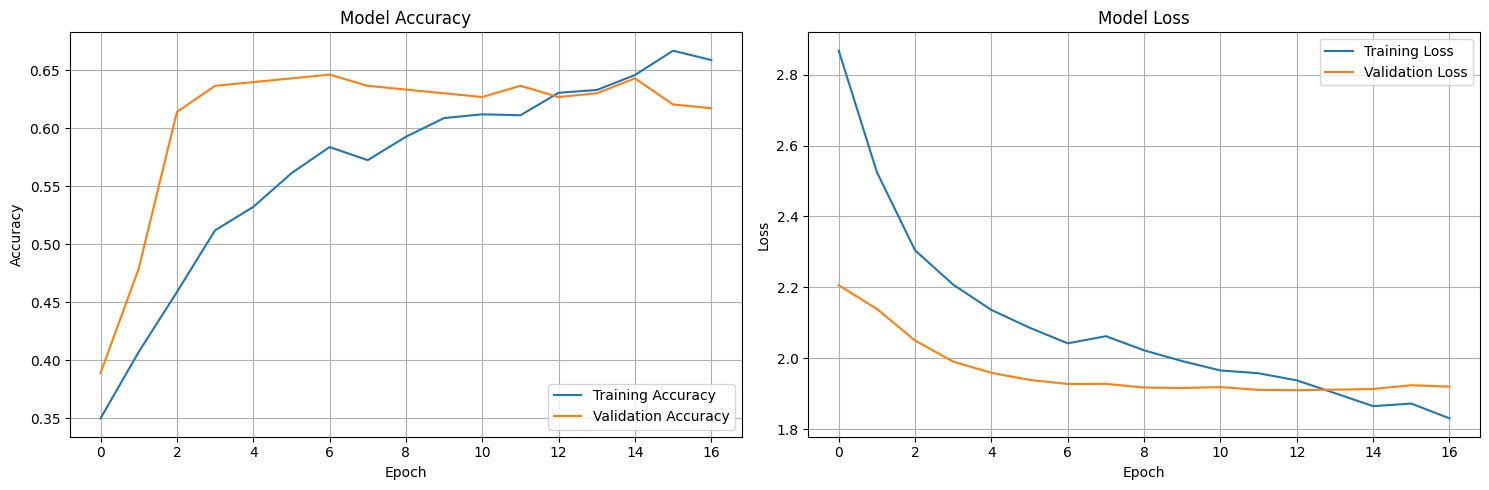

Best validation accuracy: 0.6463 (epoch 7)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6221 - loss: 1.9437
Final validation loss: 1.9275
Final validation accuracy: 0.6463
Final model saved to 'bias_detection_final_model.keras'
Best model saved to 'bias_detection_best_model.keras'


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2

def build_transformer_classifier():

    model = Sequential([
        Dense(512, kernel_regularizer=l2(0.001), input_shape=(X_train_final.shape[1],)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.5),

        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.4),

        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.3),

        Dense(y_train_final.shape[1], activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_transformer_classifier()
model.summary()


# Define callbacks
# 1. Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,       # Number of epochs with no improvement
    restore_best_weights=True,  # Restore weights from the epoch with the best value
    verbose=1
)

# 2. Model checkpoint to save best model
model_checkpoint = ModelCheckpoint(
    filepath='bias_detection_best_model.keras',  # Path to save the model
    monitor='val_accuracy',                  # Monitor validation accuracy
    save_best_only=True,                    # Only save the best model
    verbose=1
)


# Add to model.fit
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")

# Plot the training history
plot_training_history(history)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val_final, y_val_final, verbose=1)
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")

# Save the final model (in addition to the best model saved during training)
model.save('bias_detection_final_model.keras')
print("Final model saved to 'bias_detection_final_model.keras'")
print("Best model saved to 'bias_detection_best_model.keras'")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_tuned_transformer_classifier():
    model = Sequential([
        Dense(384, kernel_regularizer=l2(0.001), input_shape=(X_train_final.shape[1],)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.4),

        Dense(256, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.4),

        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.3),

        Dense(y_train_final.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model

# Build model
model = build_tuned_transformer_classifier()
model.summary()
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='bias_detection_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Train model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, model_checkpoint, lr_scheduler],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 384)            │       301,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,739 (1.67 MB)

 Trainable params: 435,203 (1.66 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3169 - loss: 2.4212
Epoch 1: val_accuracy improved from -inf to 0.42765, saving model to bias_detection_best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.3174 - loss: 2.4200 - val_accuracy: 0.4277 - val_loss: 2.0642 - learning_rate: 1.0000e-04
Epoch 2/50
75/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4404 - loss: 2.1352
Epoch 2: val_accuracy improved from 0.42765 to 0.51447, saving model to bias_detection_best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4413 - loss: 2.1346 - val_accuracy: 0.5145 - val_loss: 2.0117 - learning_rate: 1.0000e-04
Epoch 3/50
65/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4698 - loss: 2.1350
Epoch 3: val_accuracy improved from 0.51447 to 0.57235, saving model to bias_detection_best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4716 - loss: 2.1321 - val_accuracy: 0.5723 - val_loss: 1.9547 - learning_rate: 1.0000e-04
Epoch 4